# Quora Question Pair (XGBoost with Hyperparameter Tuning)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
warnings.filterwarnings("ignore")
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os

import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression

In [2]:
#prepro_features_train.csv (Simple Preprocessing Feartures)
#nlp_features_train.csv (NLP Features)
if os.path.isfile('nlp_features_train.csv'):
    dfnlp = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
else:
    print("download nlp_features_train.csv from drive or run previous notebook")

if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    dfppro = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    print("download df_fe_without_preprocessing_train.csv from drive or run previous notebook")

In [13]:
df1 = dfnlp.drop(['qid1','qid2','question1','question2'],axis=1)
df2 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3 = dfnlp[['id','question1','question2']]

In [14]:
df1.head()

,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,12.0,66,66,54,54,0.166667
3,3,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,36,36,35,40,0.039216
4,4,0,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,6.0,10.0,67,47,46,56,0.175000


In [15]:
df2.head()

,id,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [16]:
df3.head()

,id,question1,question2
0,0,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...
1,1,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...
2,2,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...
3,3,why am i mentally very lonely how can i solve...,find the remainder when math 23 24 math i...
4,4,which one dissolve in water quikly sugar salt...,which fish would survive in salt water


In [28]:
df3 = df3.fillna(' ')
#assigning new dataframe with columns question(q1+q2) and id same as df3
new_df = pd.DataFrame()
new_df['questions'] = df3.question1 + ' ' + df3.question2
new_df['id'] = df3.id
df2['id'] = df1['id']
new_df['id'] = df1['id']
df1 = df1.merge(df2, on='id',how='left') #merging df1 and df2
X  = df1.merge(new_df, on='id',how='left')#merging final_df and new_df
X.head()

,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,...,q1len_y,q2len_y,q1_n_words_y,q2_n_words_y,word_Common_y,word_Total_y,word_share_y,freq_q1+q2_y,freq_q1-q2_y,questions
0,0,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,...,66,57,14,12,10.0,23.0,0.434783,2,0,what is the step by step guide to invest in sh...
1,1,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,...,51,88,8,13,4.0,20.0,0.200000,5,3,what is the story of kohinoor koh i noor dia...
2,2,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,...,73,59,14,10,4.0,24.0,0.166667,2,0,how can i increase the speed of my internet co...
3,3,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,50,65,11,9,0.0,19.0,0.000000,2,0,why am i mentally very lonely how can i solve...
4,4,0,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,...,76,39,13,7,2.0,20.0,0.100000,4,2,which one dissolve in water quikly sugar salt...


In [29]:
data = X.sample(50000)
y_true = data['is_duplicate']
data.drop(['id','is_duplicate'],axis=1, inplace=True)
data.head()

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,...,q1len_y,q2len_y,q1_n_words_y,q2_n_words_y,word_Common_y,word_Total_y,word_share_y,freq_q1+q2_y,freq_q1-q2_y,questions
167661,0.666644,0.199998,0.166664,0.142855,0.333330,0.176470,0.0,0.0,8.0,13.0,...,43,96,8,16,2.0,24.0,0.083333,10,0,why can not i delete my messages on snapchat ...
363820,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,11.0,13.5,...,88,41,17,8,0.0,25.0,0.000000,2,0,where can i get song eeny meeny miny moe used...
95996,0.999967,0.599988,0.333322,0.199996,0.499994,0.499994,1.0,1.0,0.0,8.0,...,47,41,8,8,4.0,16.0,0.250000,3,1,how does one stop taking oneself too seriously...
399019,0.666644,0.333328,0.499975,0.124998,0.599988,0.214284,0.0,0.0,9.0,9.5,...,79,25,14,5,2.0,19.0,0.105263,7,3,will quora be blocked in mainland china by the...
391601,0.799984,0.666656,0.999975,0.999975,0.799992,0.799992,0.0,1.0,0.0,10.0,...,34,35,9,9,7.0,18.0,0.388889,2,0,how do i make dollar 1 million in 1 day how ...


# Random train test split( 70:30)

In [35]:
#spliting the data into train and test dataset (70:30) 
X_train,X_test, y_train, y_test = train_test_split(data, y_true, stratify=y_true, test_size=0.3)

In [36]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (35000, 60)
Number of data points in test data : (15000, 60)


In [37]:
X_train_ques=X_train['questions']
X_test_ques=X_test['questions']

X_train=X_train.drop('questions',axis=1)
X_test=X_test.drop('questions',axis=1)

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

tfidf = TfidfVectorizer(lowercase=False, )
tfidf.fit_transform(X_train_ques)
tfidf.transform(X_test_ques)
# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

- After we find TF-IDF scores, we convert each question to a weighted average of word2vec vectors by these scores.
- here we use a pre-trained GLOVE model which comes free with "Spacy".  https://spacy.io/usage/vectors-similarity
- It is trained on Wikipedia and therefore, it is stronger in terms of word semantics. 

In [43]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
#from spacy.lang.en.examples import sentences
import spacy
from tqdm import tqdm
nlp = spacy.load('en_core_web_sm')

vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(X_train_ques)):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), 384])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)

100%|████████████████████████████████████████████████████████████████████████████| 35000/35000 [10:14<00:00, 56.92it/s]


In [45]:
vecs2 = []
for qu2 in tqdm(list(X_test_ques)):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc2), 384])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)

100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:22<00:00, 57.21it/s]


In [46]:
df_vec1 = pd.DataFrame(vecs1)
df_vec2 = pd.DataFrame(vecs2)
from scipy.sparse import hstack
X_train = hstack((X_train,df_vec1))
X_test= hstack((X_test,df_vec2))

In [47]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (35000, 443)
Number of data points in test data : (15000, 443)


In [48]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in test data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6283142857142857 Class 1:  0.3716857142857143
---------- Distribution of output variable in test data ----------
Class 0:  0.37166666666666665 Class 1:  0.37166666666666665


In [49]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

# Machine Learning Models 

<h2> Building a random model (Finding worst-case log-loss) </h2>

Log loss on Test Data using Random Model 0.8892641919517872


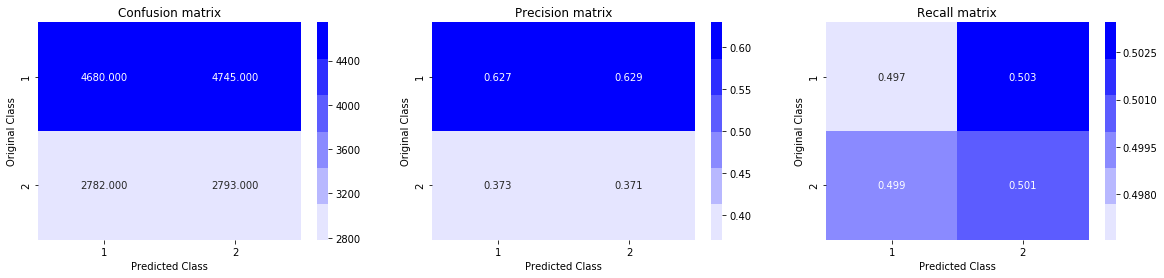

In [50]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

<h2> Logistic Regression with hyperparameter tuning </h1>

For values of alpha =  1e-05 The log loss is: 0.6598367576496094
For values of alpha =  0.0001 The log loss is: 0.5114022116344863
For values of alpha =  0.001 The log loss is: 0.5167880213149785
For values of alpha =  0.01 The log loss is: 0.5104973005616689
For values of alpha =  0.1 The log loss is: 0.5143622239602849
For values of alpha =  1 The log loss is: 0.5147662209813001
For values of alpha =  10 The log loss is: 0.5119546935846522


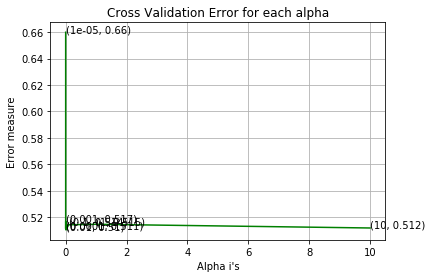

For values of best alpha =  0.01 The train log loss is: 0.49756867007011013
For values of best alpha =  0.01 The test log loss is: 0.5104973005616689
Total number of data points : 15000


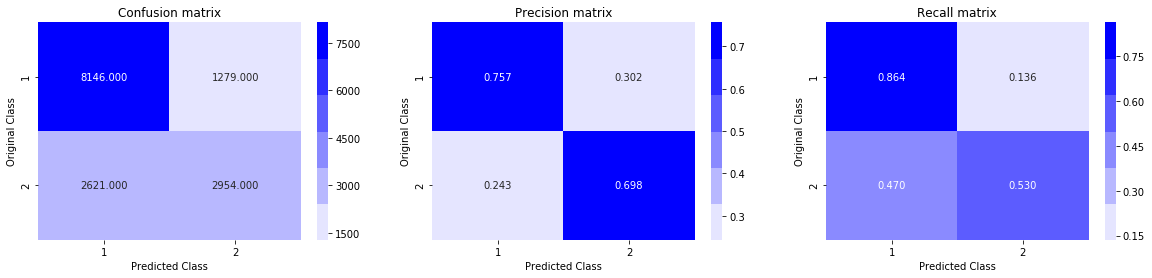

In [51]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

## Linear SVM with hyperparameter tuning

For values of alpha =  1e-05 The log loss is: 0.6598367576496094
For values of alpha =  0.0001 The log loss is: 0.522448513316957
For values of alpha =  0.001 The log loss is: 0.5056442971647908
For values of alpha =  0.01 The log loss is: 0.5610732060409224
For values of alpha =  0.1 The log loss is: 0.5971322071928302
For values of alpha =  1 The log loss is: 0.6510225407683564
For values of alpha =  10 The log loss is: 0.6598367576496094


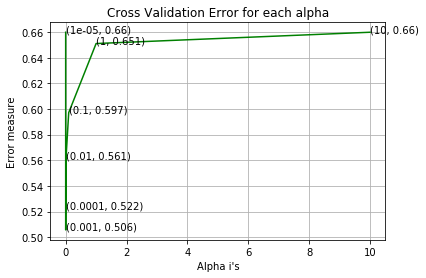

For values of best alpha =  0.001 The train log loss is: 0.49063009737836516
For values of best alpha =  0.001 The test log loss is: 0.5056442971647908
Total number of data points : 15000


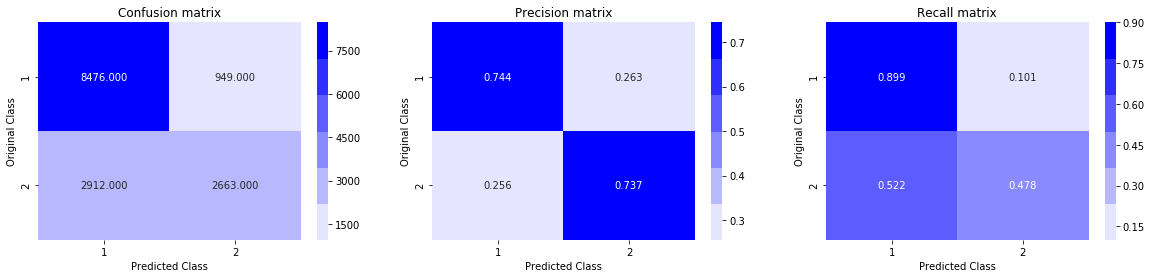

In [52]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

## Hyperparameter tune XgBoost using RandomSearch 

In [56]:
import xgboost as xgb
from scipy import stats
from sklearn.model_selection import RandomizedSearchCV

params ={ 'n_estimators': stats.randint(100, 1000, 10), 'max_depth':[3,5], 'learning_rate':[1000,100,10,1,0.1,0.01,0.001] }

xgboost_clf = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', n_jobs=-1)  

random_clf = RandomizedSearchCV(xgboost_clf, param_distributions = params, scoring='neg_log_loss', n_jobs = -1)

random_clf.fit(X_train, y_train)

print(random_clf.best_params_)

C:\Users\shiva\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 644}


Train log loss is =  0.25366066017137345  Test log loss is =  0.34020136879414714
Total number of data points : 15000


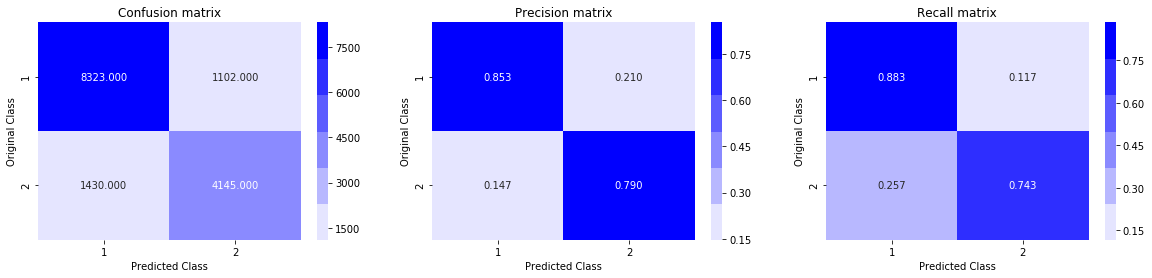

In [57]:
clf = xgb.XGBClassifier(max_depth =3,n_estimators=644, learning_rate=0.1)
clf.fit(X_train,y_train)
y_test_pred = clf.predict_proba(X_test)
y_train_pred = clf.predict_proba(X_train)
log_loss_train = log_loss(y_train, y_train_pred, eps=1e-15)
log_loss_test = log_loss(y_test, y_test_pred, eps=1e-15)
print('Train log loss is = ',log_loss_train,' Test log loss is = ',log_loss_test)
predicted_y = np.argmax(y_test_pred,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test,predicted_y)

In [59]:
from prettytable import PrettyTable    
x = PrettyTable()
x.field_names = ["Model","Vectorizer","Best Hyperperameter","Train log loss","Test log loss"]
x.add_row(['Logistic Regression','TF-IDF W2V','alpha = 0.01' ,'0.4975','0.5104'])
x.add_row(['Linear SVM','TF-IDF W2V','alpha = 0.001','0.4906','0.5056'])
x.add_row(['XGBoost Classifier','TF-IDF W2V','learning_rate=0.1\nmax_depth=3\nn_estimators=644' ,'0.2536','0.3402'])
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
printmd('****Final Conclusion:****')
print(x)

****Final Conclusion:****

+---------------------+------------+---------------------+----------------+---------------+
|        Model        | Vectorizer | Best Hyperperameter | Train log loss | Test log loss |
+---------------------+------------+---------------------+----------------+---------------+
| Logistic Regression | TF-IDF W2V |     alpha = 0.01    |     0.4975     |     0.5104    |
|      Linear SVM     | TF-IDF W2V |    alpha = 0.001    |     0.4906     |     0.5056    |
|  XGBoost Classifier | TF-IDF W2V |  learning_rate=0.1  |     0.2536     |     0.3402    |
|                     |            |     max_depth=3     |                |               |
|                     |            |   n_estimators=644  |                |               |
+---------------------+------------+---------------------+----------------+---------------+
